Для заданий 1 и 2 необходимо использовать общие данные.

Известно, что пользователь может зайти в сервис с (1) приложения на мобильном устройстве, (2) приложения на компьютере или (3) через web-интерфейс.
Соотношение методов входа следующее: 25% - (1), 30% - (2), 45% - (3). После входа на сайт пользователь выполняет одно из 3-х видов действий: покупает подписку, покупает отдельный товар, покупает подарочный сертификат.

In [1]:
import pandas as pd
pd.DataFrame([[0.3, 0.25, 0.45],
              [0.2, 0.6, 0.2],
              [0.4, 0.3, 0.2]],
             columns=['Подписка', 'Товар', 'Сертификат'],
             index=['Мобильный', 'PC', 'Web'])

,Подписка,Товар,Сертификат
Мобильный,0.3,0.25,0.45
PC,0.2,0.60,0.20
Web,0.4,0.30,0.20


Выше в таблице указаны вероятности действия пользователя при разных вариантах входа в приложение (Пример: с мобильного в 30% покупается подписка, в 25% покупается отдельный товар и тд).

## Задание 1

Посчитайте вероятность покупки сертификта при заходе через Мобильное устройство <b> или </b> через Web-интерфейс. Не забудьте про соотношение методов входа помимо матрицы вероятностей (!).

In [13]:
### YOUR SOLUTION HERE
# Фактически и первое, и второе задания можно быстро решить в уме без всякого кодирования,
# Но если предположить, что анализируемый датафрейм на самом деле имеет больший размер, займемся кодингом.

# Прежде всего создадим список соотношений методов входа, т.е. по сути вероятностей того, 
# что очередной пользователь получил доступ к сервису через соответствующий интерфейс
mode_probability = {
    'Mobile': 0.25,
    'PC': 0.3,
    'Web': 0.45
}

# Также переопределим датафрейм с условными вероятностями выполнения определенных видов действий в зависимости от метода входа
# ВАЖНО!Анализ условных вероятностей в исходном датасете позволяет выявить противоречие между условиями задачи и этими данными
# В последней строке с вероятностями входа через Web-интерфейс сумма вероятностей покупки товаров НЕ РАВНА 1.
# В этой связи можно компенсировать эту ошибку в данных разными способами. Один - недостающую вероятность 0.1 разделить 
# пропорционально текущим значениям вероятностей, т.е. просто провести нормализацию этих значений.
# Другой вариант - добавить эту вероятность случайно к значению любой из колонок, 
# Третий вариант - добавить еще одну колонку "Ничего не куплено" и поставить для первых двух строк 0, а для третьей - 0.1
# Я выбираю третий вариант, поэтому в датасет добавляю еще одну колонку.
mode_actions_probabilities = pd.DataFrame(
    [[0.3, 0.25, 0.45, 0.],
    [0.2, 0.6, 0.2, 0.],
    [0.4, 0.3, 0.2, 0.1]],
    columns=['Subscription', 'Product', 'Sertificate', 'Nothing'],
    index=['Mobile', 'PC', 'Web']
)

# Если необходимо определить вероятность того, что произойдет любое событие из нескольких событий, 
# то такая вероятность определяется как сумма вероятностей каждого из событий
# При этом в нашем случае у нас каждое событие - сложное и является комбинацией двух условий, 
# которые должны произойти одновременно. Вероятность такого события, в свою очередь, равно произведению вероятностей
# тех условий, которые образуют это событие.

# Вероятность того, что пользователь войдет через мобильное приложение и потом купить сертификат:
mobile_sertificate = mode_probability['Mobile'] * mode_actions_probabilities.Sertificate['Mobile']

# Вероятность того, что пользователь войдет через мобильное приложение и потом купит сертификат:
web_sertificate = mode_probability['Web'] * mode_actions_probabilities.Sertificate['Web']

print(f'Искомая вероятность {mobile_sertificate + web_sertificate}')
print(f'(вход через мобильные - {mobile_sertificate}, вход через Web {web_sertificate})')

Искомая вероятность 0.2025
(вход через мобильные - 0.1125, вход через Web 0.09000000000000001)


## Задание 2

Оказалось, что в коде сервиса был допущен баг, и информация о типе входа не записывалась в базу для каждого пользователя. Было принято решение для каждого типа покупки выбрать наиболее вероятный тип входа в сервис и записать эти значения в базу данных. Для каждого типа покупки вычислите это значение, принимая во внимание соотношение методов входа и матрицу вероятностей.

In [27]:
### YOUR SOLUTION HERE
# Фактически задача заключается в следующем. Для каждой ячейки нашего датафрейма (типа покупки) надо посчитать
# произведение этой условной вероятности на вероятность того, что пользователь зашел через конкретный интерфейс.
# В результате получится матрица, сумма всех значений которой должна быть равной 1.
# После получения этой матрицы для каждого типа товара выбирается способ входа с максимальной вероятностью.
# Для упрощения задачи считаем, что если максимальная вероятность для конкретного товара 
# будет совпадать для двух или трех типов входа, выберем первый из встретившихся в цикле типов.

# Итак, вначале создаем пустую матрицу и заполняем ее:
cond_prob = pd.DataFrame(
    columns=['Subscription', 'Product', 'Sertificate', 'Nothing'],
    index=['Mobile', 'PC', 'Web']
)

#print(cond_prob)
# Созданим словарь, в котором сохраним наиболее вероятный тип входа в зависимости от того, что купил пользователь
res_ = {}
contr_sum = 0
for col, fld in mode_actions_probabilities.items():
    # Для текущей колонки создаем переменную для хранения максимального значения вероятности
    col_max=0
    for row, val in fld.items():
        cond_prob[col][row] = val*mode_probability[row]
        contr_sum += cond_prob[col][row]
        if cond_prob[col][row] > col_max:
            col_max = cond_prob[col][row]
            res_[col] = row
print(f'Контрольная сумма (должна быть 1): {contr_sum}')
print(cond_prob)
print('\nРезультат - словарь, индекс которого - продукт, а значение - соответствующий тип входа\n', res_)

Контрольная сумма (должна быть 1): 1.0000000000000002
       Subscription Product Sertificate Nothing
Mobile        0.075  0.0625      0.1125     0.0
PC             0.06    0.18        0.06     0.0
Web            0.18   0.135        0.09   0.045

Результат - словарь, индекс которого - продукт, а значение - соответствующий тип входа
 {'Subscription': 'Web', 'Product': 'PC', 'Sertificate': 'Mobile', 'Nothing': 'Web'}


## Задание 3

Изучите 4 распределения из библиотеки scipy: нормальное, экспоненциальное, Стьюдента, Бета. Используя функцию плотности распредления, постройте несколько графиков плотностей для каждого распределения при разных параметрах. Запишите ваши наблюдения: как и на что влияют параметры у каждого распределения.

In [48]:
### YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

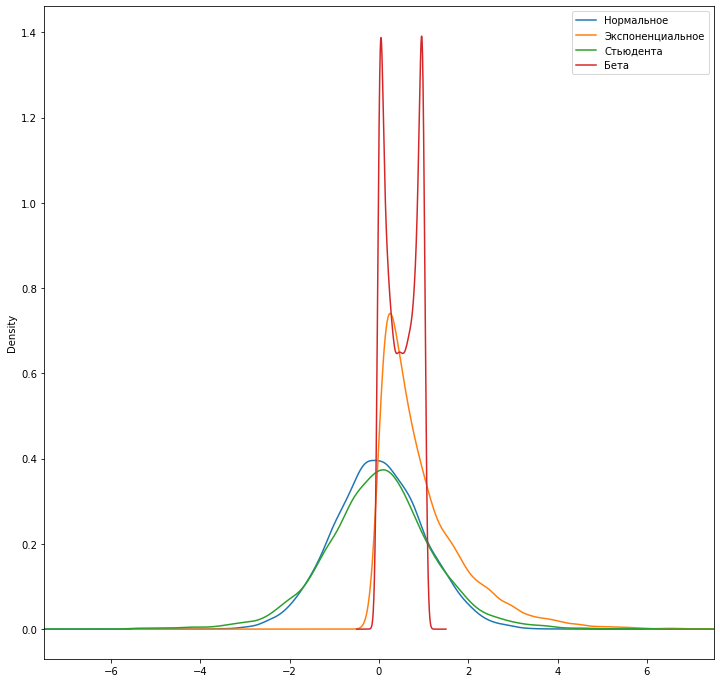

In [96]:
# Вначале на одной диаграмме отразим все распределения c похожими исходными данными по выборкам
# Здесь и далее используется метод plot.kde, который имеется у объекта Series 
# и позволяет отобразить функцию плотности распределения

plt.figure(figsize=(12,12))

disp_normal = np.random.normal(scale=1.0, size=10000)
distr_normal = pd.Series(disp_normal)
distr_normal.plot.kde(label='Нормальное')

disp_exp = np.random.exponential(scale=1.0, size=10000)
distr_exp = pd.Series(disp_exp)
distr_exp.plot.kde(label='Экспоненциальное')

disp_student = np.random.standard_t(df=5, size=10000)
distr_student = pd.Series(disp_student)
distr_student.plot.kde(label='Стьюдента')

disp_beta = np.random.beta(a=0.5, b=0.5, size=10000)
distr_beta = pd.Series(disp_beta)
distr_beta.plot.kde(label='Бета')

plt.axis(xmin=-7.5, xmax=7.5)
plt.legend()

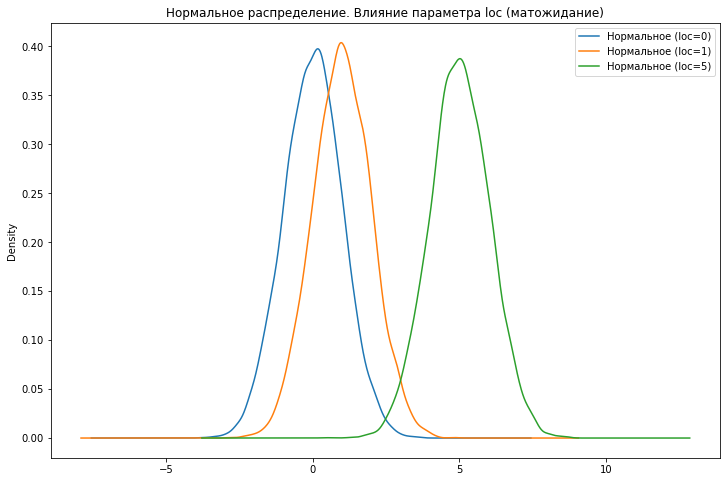

In [112]:
# Теперь несколько экспериментов с нормальным распределением (ссылки - для себя)
# https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

# Проанализируем три параметра 

plt.figure(figsize=(12,8))

# Параметр loc определяет положение матожидания, примерную позицию максимума кривой при большом объеме выборки
pd.Series(np.random.normal(loc=0, scale=1.0, size=10000)).plot.kde(label='Нормальное (loc=0)')
pd.Series(np.random.normal(loc=1, scale=1.0, size=10000)).plot.kde(label='Нормальное (loc=1)')
pd.Series(np.random.normal(loc=5, scale=1.0, size=10000)).plot.kde(label='Нормальное (loc=5)')
plt.title('Нормальное распределение. Влияние параметра loc (матожидание)')
plt.legend()

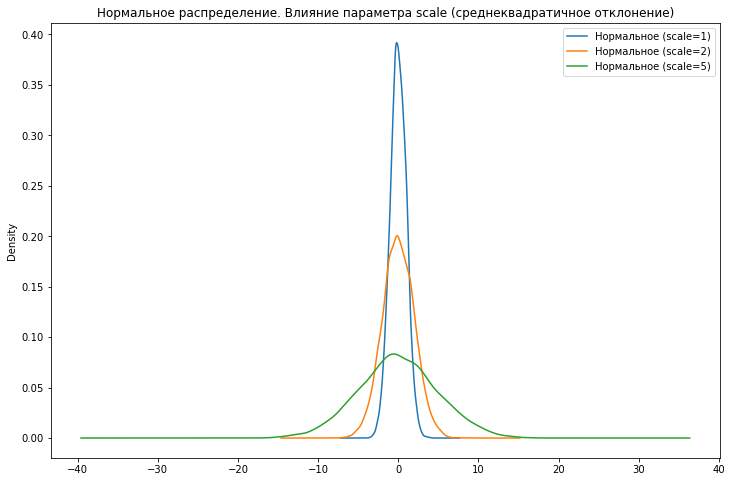

In [111]:
plt.figure(figsize=(12,8))

# Параметр scale определяет величину среднеквадратичного отклонения.
# Это - положительное число. Чем оно выше, тем более широким будет колокол. При стремлении к 0 кривая вырождается в вертикаль
pd.Series(np.random.normal(loc=0, scale=1.0, size=10000)).plot.kde(label='Нормальное (scale=1)')
pd.Series(np.random.normal(loc=0, scale=2.0, size=10000)).plot.kde(label='Нормальное (scale=2)')
pd.Series(np.random.normal(loc=0, scale=5.0, size=10000)).plot.kde(label='Нормальное (scale=5)')
plt.title('Нормальное распределение. Влияние параметра scale (среднеквадратичное отклонение)')
plt.legend()

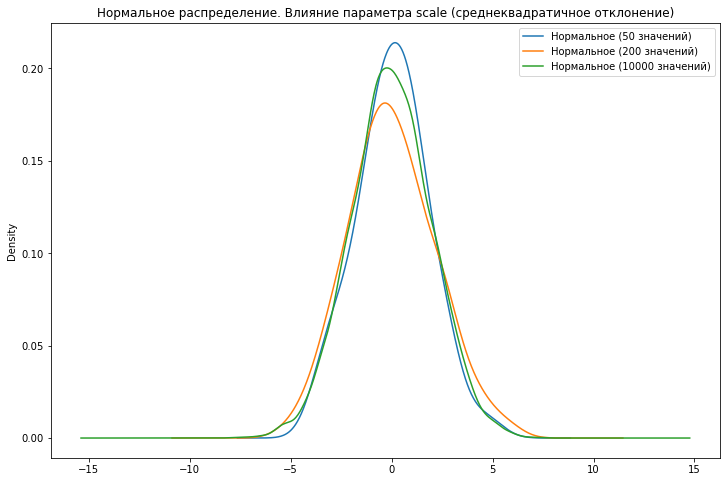

In [110]:
plt.figure(figsize=(12,8))

# Параметр size определяет объем выборки.
# Чем больше выборка, тем более гладкой оказывается кривая и тем точнее максимум кривой оказывается в районе матожидания
# Кроме того, при каждом запуске размещенного ниже кода кривые с малым количеством данных будут сильно отличаться 
pd.Series(np.random.normal(loc=0, scale=2.0, size=50)).plot.kde(label='Нормальное (50 значений)')
pd.Series(np.random.normal(loc=0, scale=2.0, size=200)).plot.kde(label='Нормальное (200 значений)')
pd.Series(np.random.normal(loc=0, scale=2.0, size=10000)).plot.kde(label='Нормальное (10000 значений)')
plt.title('Нормальное распределение. Влияние параметра scale (среднеквадратичное отклонение)')
plt.legend()

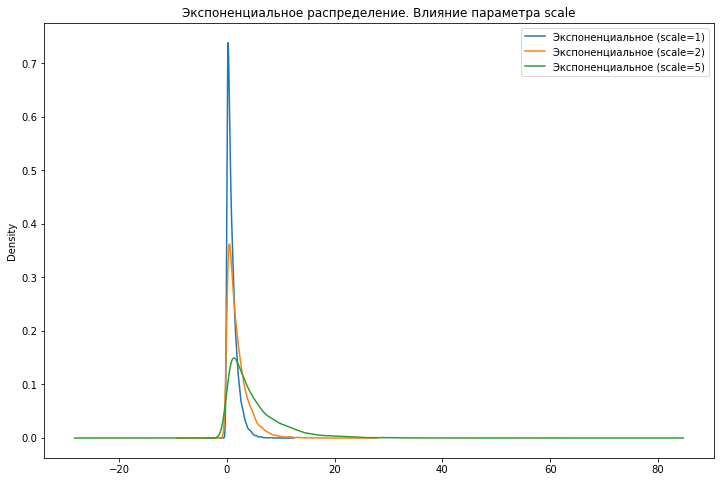

In [109]:
# Экспоненциальное распределение (ссылки - для себя)
# https://ru.wikipedia.org/wiki/%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html

# Проанализируем два параметра, определяющие правила формирования выборки: scale и size

plt.figure(figsize=(12,8))

# Параметр scale 
pd.Series(np.random.exponential(scale=1.0, size=10000)).plot.kde(label='Экспоненциальное (scale=1)')
pd.Series(np.random.exponential(scale=2.0, size=10000)).plot.kde(label='Экспоненциальное (scale=2)')
pd.Series(np.random.exponential(scale=5.0, size=10000)).plot.kde(label='Экспоненциальное (scale=5)')
plt.title('Экспоненциальное распределение. Влияние параметра scale')
plt.legend()

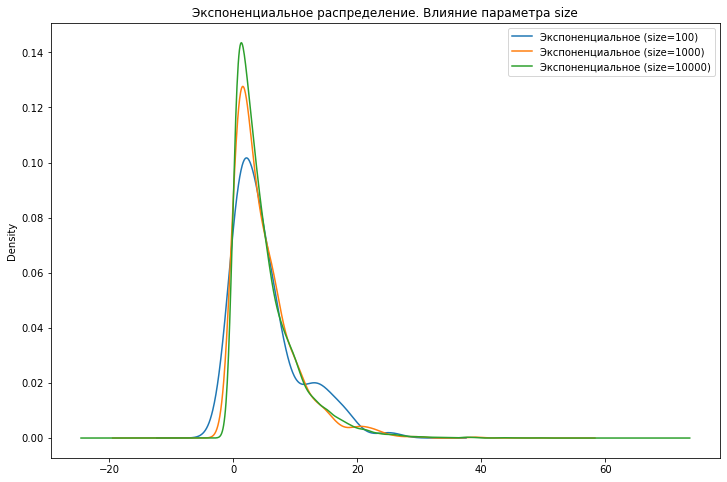

In [114]:
plt.figure(figsize=(12,8))

# Параметр size определяет объем выборки.
# Чем больше выборка, тем более гладкой оказывается кривая
# Как и для норм. распределения, при каждом запуске размещенного ниже кода кривые с малым количеством данных будут сильно отличаться 
pd.Series(np.random.exponential(scale=5.0, size=100)).plot.kde(label='Экспоненциальное (size=100)')
pd.Series(np.random.exponential(scale=5.0, size=1000)).plot.kde(label='Экспоненциальное (size=1000)')
pd.Series(np.random.exponential(scale=5.0, size=10000)).plot.kde(label='Экспоненциальное (size=10000)')
plt.title('Экспоненциальное распределение. Влияние параметра size')
plt.legend()

(-15.0, 15.0, -0.017816355809237943, 0.37414347199399683)

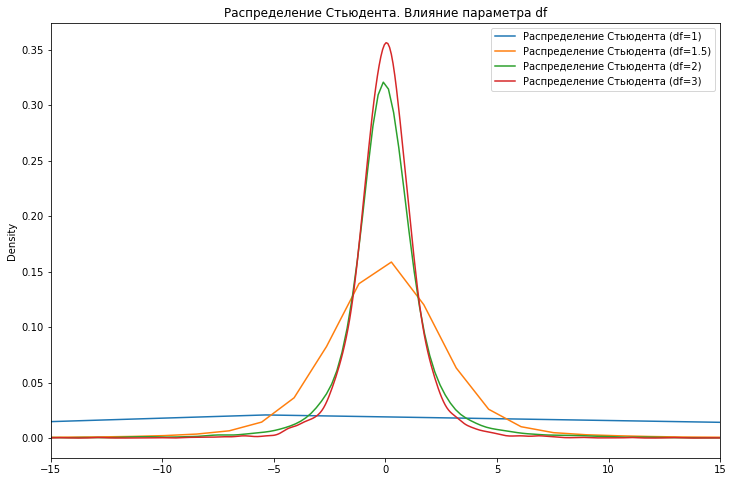

In [131]:
# Распределение Стьюдента (ссылки - для себя)
# https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_t.html

# Проанализируем два параметра, определяющие правила формирования выборки: df и size

plt.figure(figsize=(12,8))

# Параметр df - это степени свободы. Положительное число. Если df=1, распределение похоже на горизонтальную линию,
# по мере того, как df увеличивается, колокол распределения растет.
# Сильно напоминает нормальное распределение, но согласно Википедии, имеет "более тяжелые хвосты" по сравнению с нормальным.
pd.Series(np.random.standard_t(df=1, size=10000)).plot.kde(label='Распределение Стьюдента (df=1)')
pd.Series(np.random.standard_t(df=1.5, size=10000)).plot.kde(label='Распределение Стьюдента (df=1.5)')
pd.Series(np.random.standard_t(df=2, size=10000)).plot.kde(label='Распределение Стьюдента (df=2)')
pd.Series(np.random.standard_t(df=3, size=10000)).plot.kde(label='Распределение Стьюдента (df=3)')
plt.title('Распределение Стьюдента. Влияние параметра df')
plt.legend()
plt.axis(xmin=-15, xmax=15)

(-15.0, 15.0, -0.020625259570320492, 0.4331304509767303)

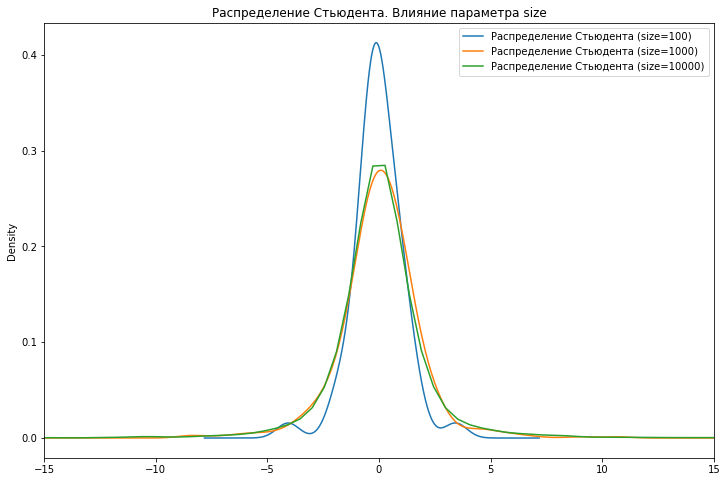

In [140]:
plt.figure(figsize=(12,8))

# Параметр size ведет себя так же, как и для других распределений.
# Чем больше выборка, тем более гладкой оказывается кривая.
# Интересно, что высота распределений для каждой из выборок при повторных запусках меняется сильно и не зависит от объема выборки
pd.Series(np.random.standard_t(df=2, size=50)).plot.kde(label='Распределение Стьюдента (size=100)')
pd.Series(np.random.standard_t(df=2, size=500)).plot.kde(label='Распределение Стьюдента (size=1000)')
pd.Series(np.random.standard_t(df=2, size=10000)).plot.kde(label='Распределение Стьюдента (size=10000)')
plt.title('Распределение Стьюдента. Влияние параметра size')
plt.legend()
plt.axis(xmin=-15, xmax=15)

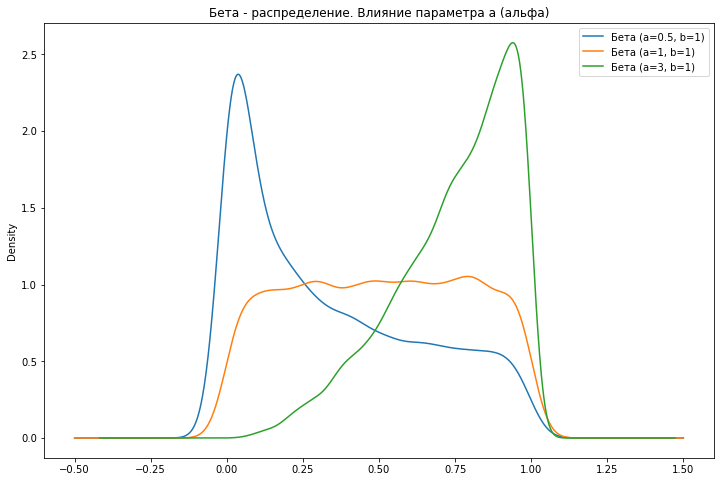

In [116]:
# Бета-распределение (ссылки - для себя)
# https://ru.wikipedia.org/wiki/%D0%91%D0%B5%D1%82%D0%B0-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.beta.html

# Это распределение используется для описания случайных величин, значения которых ограничены конечным интервалом
# Проанализируем три параметра, определяющие правила формирования выборки: a, b и size

plt.figure(figsize=(12,8))

# Параметр a, Альфа. Должен быть позитивным 
pd.Series(np.random.beta(a=0.5, b=1, size=10000)).plot.kde(label='Бета (a=0.5, b=1)')
pd.Series(np.random.beta(a=1, b=1, size=10000)).plot.kde(label='Бета (a=1, b=1)')
pd.Series(np.random.beta(a=3, b=1, size=10000)).plot.kde(label='Бета (a=3, b=1)')
plt.title('Бета - распределение. Влияние параметра a (альфа)')
plt.legend()

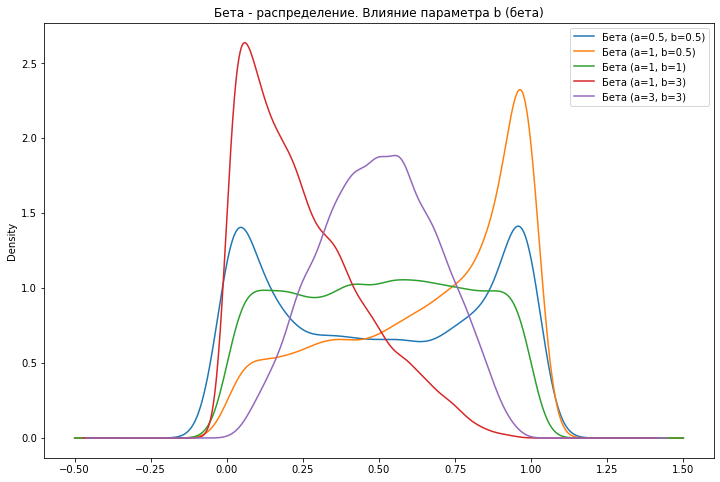

In [120]:
plt.figure(figsize=(12,8))

# Параметр b, Beta. Тоже должен быть позитивным. 
# На этом же графике можно посмотреть и три случая равенства a и b: когда они меньше единицы, равны единице и больше единицы
# Видно, что при равенстве этих параметров форма кривой стремится к симметричному виду.
# Если a > b, то максимум кривой приближается к правой границе, и наоборот.
pd.Series(np.random.beta(a=0.5, b=0.5, size=10000)).plot.kde(label='Бета (a=0.5, b=0.5)')
pd.Series(np.random.beta(a=1, b=0.5, size=10000)).plot.kde(label='Бета (a=1, b=0.5)')
pd.Series(np.random.beta(a=1, b=1, size=10000)).plot.kde(label='Бета (a=1, b=1)')
pd.Series(np.random.beta(a=1, b=3, size=10000)).plot.kde(label='Бета (a=1, b=3)')
pd.Series(np.random.beta(a=3, b=3, size=10000)).plot.kde(label='Бета (a=3, b=3)')
plt.title('Бета - распределение. Влияние параметра b (бета)')
plt.legend()

In [ ]:
plt.figure(figsize=(12,8))

# Параметр a, Альфа. Должен быть позитивным 
pd.Series(np.random.beta(a=0.5, b=1, size=10000)).plot.kde(label='Бета (a=0.5, b=1)')
pd.Series(np.random.beta(a=1, b=1, size=10000)).plot.kde(label='Бета (a=1, b=1)')
pd.Series(np.random.beta(a=3, b=1, size=10000)).plot.kde(label='Бета (a=3, b=1)')
plt.title('Бета - распределение. Влияние параметра a (альфа)')
plt.legend()